## Chargement de la base de données.

In [137]:
import pandas as pd

df= pd.read_excel("/Users/mathias/Desktop/Stat'App/ENSAE_Vietnam_geo-analysis_database/1. Facts/Districts data.xlsx")

df.head()

,OBJECTID,ID,NAME,2018 Total Population,2018 Population Density (per sq. km),2018 Population Per Mill,2018 Total Male Population,2018 Total Female Population,2018 Total Households,2018 Average Household Size,...,2018 Personal Care: Index,2018 Personal Effects: Total,2018 Personal Effects: Per Mill,2018 Personal Effects: Per Capita,2018 Personal Effects: Index,AREA,grid_code,RG_NAME,Shape__Area,Shape__Length
0,1,1001,Quận Ba Đình,245551,26394.8,2.6,118593,126958,66303,3.7,...,132.9,8.801580e+10,4.9,358442.05,190.2,9.303019,471215,Thành phố Hà Nội,1.060136e+07,19745.154516
1,2,1002,Quận Hoàn Kiếm,158799,28821.0,1.7,76858,81941,42383,3.7,...,127.3,5.337166e+10,3.0,336095.70,178.3,5.509843,248515,Thành phố Hà Nội,6.417896e+06,10122.627004
2,3,1003,Quận Tây Hồ,161876,6743.5,1.7,78989,82887,43082,3.8,...,125.8,5.223855e+10,2.9,322707.17,171.2,24.004685,420271,Thành phố Hà Nội,2.775605e+07,27415.577234
3,4,1004,Quận Long Biên,281598,4880.1,3.0,138675,142923,78111,3.6,...,125.6,8.677468e+10,4.9,308150.90,163.5,57.703097,1206280,Thành phố Hà Nội,6.649612e+07,34518.571911
4,5,1005,Quận Cầu Giấy,263828,21229.9,2.8,123450,140378,76273,3.5,...,140.5,9.722844e+10,5.5,368529.63,195.5,12.427213,622769,Thành phố Hà Nội,1.434960e+07,25685.328783


## Scaling

In [138]:
#Détermination des colonnes non numériques

num_col = []
non_num_col = []
columns=df.columns.values
for i in range(len(df.dtypes)):
    typ=df.dtypes[i]
    if typ == 'float64':
        num_col.append(columns[i])
    elif typ == 'int64':
        num_col.append(columns[i])
    else :
        non_num_col.append(columns[i])
        
print(num_col)

['OBJECTID', 'ID', '2018 Total Population', '2018 Population Density (per sq. km)', '2018 Population Per Mill', '2018 Total Male Population', '2018 Total Female Population', '2018 Total Households', '2018 Average Household Size', '2018 Total Population Age 0-14', '2018 Total Population Age 15-29', '2018 Total Population Age 30-44', '2018 Total Population Age 45-59', '2018 Total Population Age 60+', '2018 Male Population Age 0-14', '2018 Male Population Age 15-29', '2018 Male Population Age 30-44', '2018 Male Population Age 45-59', '2018 Male Population Age 60+', '2018 Female Population Age 0-14', '2018 Female Population Age 15-29', '2018 Female Population Age 30-44', '2018 Female Population Age 45-59', '2018 Female Population Age 60+', '2018 Pop 15+/Edu: Pre-school', '2018 Pop 15+/Edu: Primary', '2018 Pop 15+/Edu: Lower Secondary', '2018 Pop 15+/Edu: Short Term Training', '2018 Pop 15+/Edu: Higher Secondary', '2018 Pop 15+/Edu: Trade Vocational School', '2018 Pop 15+/Edu: Vocational Sc

In [139]:
print(non_num_col)

['NAME', 'RG_NAME']


In [140]:
# On supprime 

In [141]:
dfb=df

In [142]:
dfb.head()

,OBJECTID,ID,NAME,2018 Total Population,2018 Population Density (per sq. km),2018 Population Per Mill,2018 Total Male Population,2018 Total Female Population,2018 Total Households,2018 Average Household Size,...,2018 Personal Care: Index,2018 Personal Effects: Total,2018 Personal Effects: Per Mill,2018 Personal Effects: Per Capita,2018 Personal Effects: Index,AREA,grid_code,RG_NAME,Shape__Area,Shape__Length
0,1,1001,Quận Ba Đình,245551,26394.8,2.6,118593,126958,66303,3.7,...,132.9,8.801580e+10,4.9,358442.05,190.2,9.303019,471215,Thành phố Hà Nội,1.060136e+07,19745.154516
1,2,1002,Quận Hoàn Kiếm,158799,28821.0,1.7,76858,81941,42383,3.7,...,127.3,5.337166e+10,3.0,336095.70,178.3,5.509843,248515,Thành phố Hà Nội,6.417896e+06,10122.627004
2,3,1003,Quận Tây Hồ,161876,6743.5,1.7,78989,82887,43082,3.8,...,125.8,5.223855e+10,2.9,322707.17,171.2,24.004685,420271,Thành phố Hà Nội,2.775605e+07,27415.577234
3,4,1004,Quận Long Biên,281598,4880.1,3.0,138675,142923,78111,3.6,...,125.6,8.677468e+10,4.9,308150.90,163.5,57.703097,1206280,Thành phố Hà Nội,6.649612e+07,34518.571911
4,5,1005,Quận Cầu Giấy,263828,21229.9,2.8,123450,140378,76273,3.5,...,140.5,9.722844e+10,5.5,368529.63,195.5,12.427213,622769,Thành phố Hà Nội,1.434960e+07,25685.328783


In [143]:
num_col[2:]

['2018 Total Population',
 '2018 Population Density (per sq. km)',
 '2018 Population Per Mill',
 '2018 Total Male Population',
 '2018 Total Female Population',
 '2018 Total Households',
 '2018 Average Household Size',
 '2018 Total Population Age 0-14',
 '2018 Total Population Age 15-29',
 '2018 Total Population Age 30-44',
 '2018 Total Population Age 45-59',
 '2018 Total Population Age 60+',
 '2018 Male Population Age 0-14',
 '2018 Male Population Age 15-29',
 '2018 Male Population Age 30-44',
 '2018 Male Population Age 45-59',
 '2018 Male Population Age 60+',
 '2018 Female Population Age 0-14',
 '2018 Female Population Age 15-29',
 '2018 Female Population Age 30-44',
 '2018 Female Population Age 45-59',
 '2018 Female Population Age 60+',
 '2018 Pop 15+/Edu: Pre-school',
 '2018 Pop 15+/Edu: Primary',
 '2018 Pop 15+/Edu: Lower Secondary',
 '2018 Pop 15+/Edu: Short Term Training',
 '2018 Pop 15+/Edu: Higher Secondary',
 '2018 Pop 15+/Edu: Trade Vocational School',
 '2018 Pop 15+/Edu: Voc

In [144]:
dfb[num_col[2:]]

,2018 Total Population,2018 Population Density (per sq. km),2018 Population Per Mill,2018 Total Male Population,2018 Total Female Population,2018 Total Households,2018 Average Household Size,2018 Total Population Age 0-14,2018 Total Population Age 15-29,2018 Total Population Age 30-44,...,2018 Personal Care: Per Capita,2018 Personal Care: Index,2018 Personal Effects: Total,2018 Personal Effects: Per Mill,2018 Personal Effects: Per Capita,2018 Personal Effects: Index,AREA,grid_code,Shape__Area,Shape__Length
0,245551,26394.8,2.6,118593,126958,66303,3.7,49412,61908,52599,...,951238.01,132.9,8.801580e+10,4.9,358442.05,190.2,9.303019,471215,1.060136e+07,19745.154516
1,158799,28821.0,1.7,76858,81941,42383,3.7,30035,38789,32047,...,911218.80,127.3,5.337166e+10,3.0,336095.70,178.3,5.509843,248515,6.417896e+06,10122.627004
2,161876,6743.5,1.7,78989,82887,43082,3.8,34211,42975,35195,...,900922.66,125.8,5.223855e+10,2.9,322707.17,171.2,24.004685,420271,2.775605e+07,27415.577234
3,281598,4880.1,3.0,138675,142923,78111,3.6,63247,77014,65160,...,898958.11,125.6,8.677468e+10,4.9,308150.90,163.5,57.703097,1206280,6.649612e+07,34518.571911
4,263828,21229.9,2.8,123450,140378,76273,3.5,44907,110791,48724,...,1005898.90,140.5,9.722844e+10,5.5,368529.63,195.5,12.427213,622769,1.434960e+07,25685.328783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,140755,337.2,1.5,70378,70377,32907,4.3,34063,44082,30451,...,627599.01,87.7,2.054595e+10,1.2,145969.61,77.4,417.409785,42145,4.302020e+08,95375.181298
707,188348,232.1,2.0,93841,94507,43029,4.4,48940,58992,41523,...,611576.31,85.4,2.555806e+10,1.4,135695.96,72.0,811.551773,11286,8.374241e+08,130464.696975
708,65506,142.7,0.7,33174,32332,16640,3.9,17579,19996,14738,...,687944.57,96.1,1.092790e+10,0.6,166822.84,88.5,459.009102,47217,4.730924e+08,140193.345872
709,106956,247.6,1.1,53858,53098,24978,4.3,28091,34044,22869,...,619720.56,86.6,1.454268e+10,0.8,135968.85,72.1,432.034322,11700,4.448235e+08,102367.266184


On standardise la base de données.

### Avant la standardisation

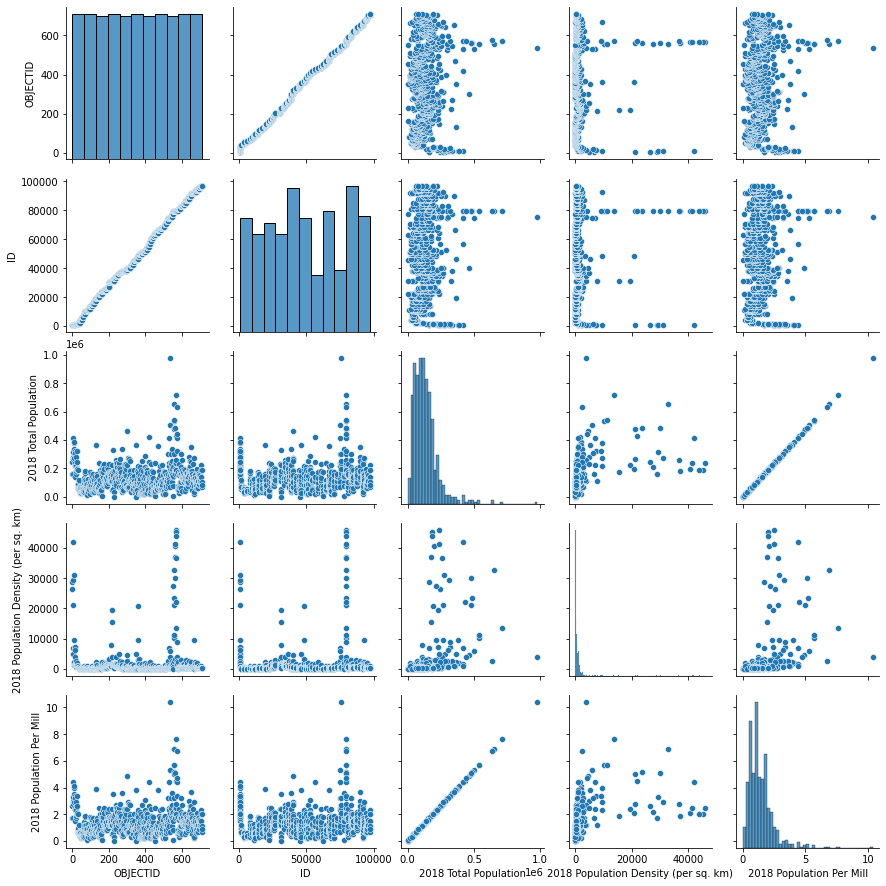

In [145]:
import seaborn as sns
#On regarde que pour les 5 premières colonnes
sns.pairplot(dfb[num_col[:5]])


### Après la standardisation

In [438]:
import sklearn.preprocessing as proc
dfstd = pd.DataFrame(proc.StandardScaler().fit_transform(dfb[num_col[2:]]))
#on ne transforme pas les id
dfstd.columns = num_col[2:]
# Question devons-nous aussi ne pas standardiser d'autres id.
dfstd['OBJECTID']=df['OBJECTID']
dfstd['ID']=df['ID']

#Suppression de la géographie.
#dfstd=dfstd.drop(['AREA', 'grid_code','Shape__Area','Shape__Length'], axis=1)

In [411]:
dfstd.head()

,2018 Total Population,2018 Population Density (per sq. km),2018 Population Per Mill,2018 Total Male Population,2018 Total Female Population,2018 Total Households,2018 Average Household Size,2018 Total Population Age 0-14,2018 Total Population Age 15-29,2018 Total Population Age 30-44,...,2018 Personal Care: Total,2018 Personal Care: Per Mill,2018 Personal Care: Per Capita,2018 Personal Care: Index,2018 Personal Effects: Total,2018 Personal Effects: Per Mill,2018 Personal Effects: Per Capita,2018 Personal Effects: Index,OBJECTID,ID
0,1.172932,4.371231,1.174854,1.145318,1.197247,1.178445,-0.574800,0.859270,0.668324,0.965525,...,1.658915,1.699151,2.528181,2.531123,2.236510,2.208233,3.062110,3.062562,1,1001
1,0.269706,4.800761,0.289250,0.244582,0.292774,0.285228,-0.574800,-0.121110,-0.014425,0.088041,...,0.593785,0.563188,2.160605,2.162868,1.006016,1.006871,2.710404,2.709578,2,1002
2,0.301742,0.892201,0.289250,0.290574,0.311781,0.311330,-0.350742,0.090175,0.109196,0.222448,...,0.607413,0.644328,2.066035,2.064229,0.965770,0.943641,2.499684,2.498975,3,1003
3,1.548238,0.562308,1.568455,1.578733,1.518012,1.619377,-0.798859,1.559252,1.114433,1.501826,...,1.893416,1.861431,2.047991,2.051077,2.192428,2.208233,2.270585,2.270573,4,1004
4,1.363224,3.456847,1.371654,1.250143,1.466879,1.550743,-1.022917,0.631339,2.111932,0.800079,...,2.040099,2.023711,3.030241,3.030898,2.563726,2.587610,3.220877,3.219773,5,1005


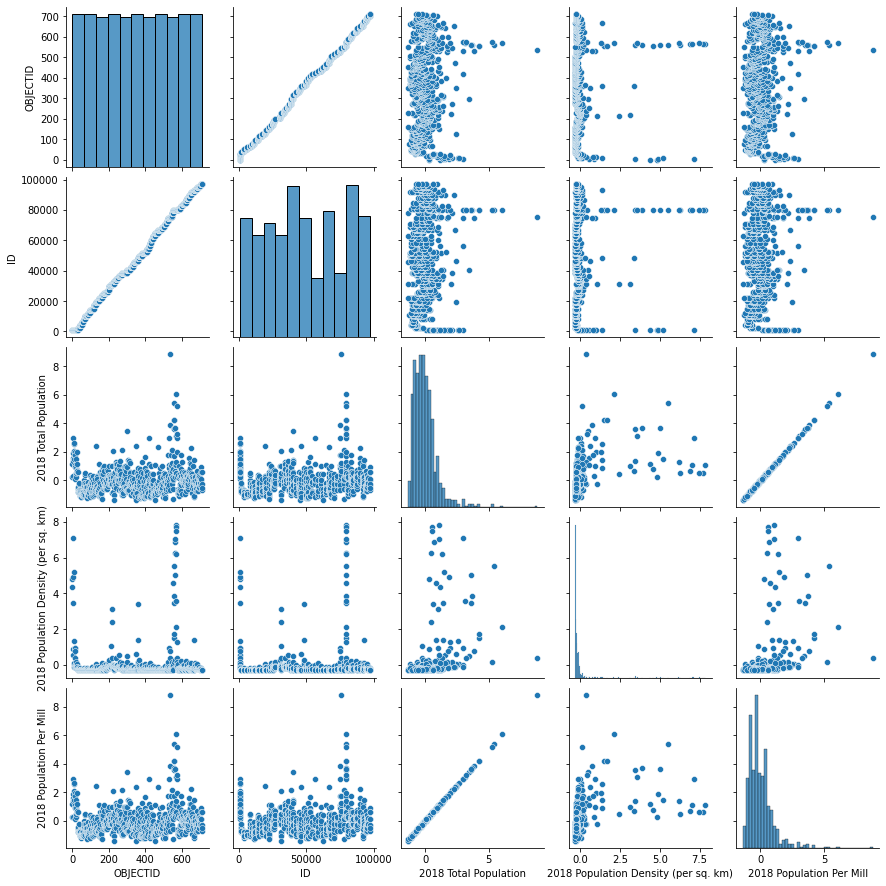

In [148]:
sns.pairplot(dfstd[num_col[:5]])

# Détermination du nombre optimal de cluster

## Kmeans

#### Elbow method

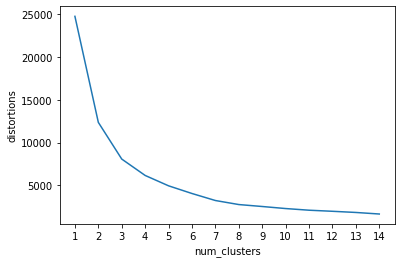

In [350]:
#Elbow Method
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans, vq
distortions = []
num_clusters = range(1, 15)

# Create a list of distortions from the kmeans function
for i in num_clusters:
    cluster_centers, distortion = kmeans(dfstd,i)
    distortions.append(distortion)

# Create a data frame with two lists - num_clusters, distortions
elbow_plot = pd.DataFrame({'num_clusters': num_clusters, 'distortions': distortions})

# Creat a line plot of num_clusters and distortions
sns.lineplot(x='num_clusters', y='distortions', data = elbow_plot)
plt.xticks(num_clusters)
plt.show()

Il semble que le nombre optimal de cluster avec une méthode de k-means soit de l'ordre de 3-5;

## Clustering hierrchique ascendant 

Methode ward

In [310]:
 # Import the fcluster and linkage functions
from scipy.cluster.hierarchy import fcluster, linkage

# Use the linkage() function
distance_matrix = linkage(dfstd, method = 'ward', metric = 'euclidean')


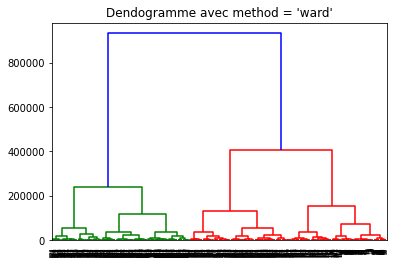

In [311]:
# Dendogramme
# Pour faire les dendogrammes

# Import the dendrogram function
from scipy.cluster.hierarchy import dendrogram

# Create a dendrogram
dn = dendrogram(distance_matrix)

# Display the dendogram
plt.title("Dendogramme avec method = 'ward'")
plt.show()

Methode complete

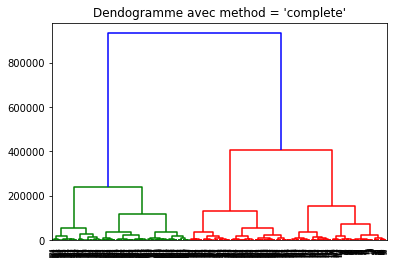

In [99]:
# Use the linkage() function
distance_matrix_complete = linkage(dfstd, method = 'complete', metric = 'euclidean')

dn = dendrogram(distance_matrix)

# Display the dendogram
plt.title("Dendogramme avec method = 'complete'")
plt.show()

Methode average

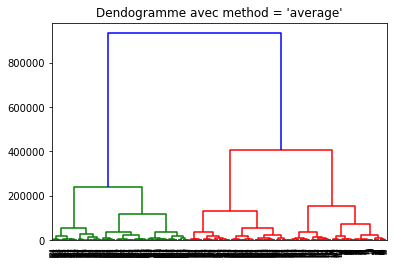

In [100]:
# Use the linkage() function
distance_matrix_complete = linkage(dfstd, method = 'average', metric = 'euclidean')

dn = dendrogram(distance_matrix)

# Display the dendogram
plt.title("Dendogramme avec method = 'average'")
plt.show()

Methode single

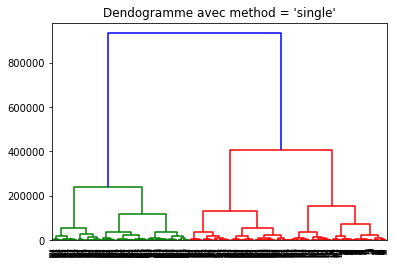

In [122]:
# Use the linkage() function
distance_matrix_complete = linkage(dfstd, method = 'single', metric = 'euclidean')

dn = dendrogram(distance_matrix)

# Display the dendogram
plt.title("Dendogramme avec method = 'single'")
plt.show()

# -----------------------------------------------------------------------------------------

# Mise à plat sur une carte

In [439]:
dfstd['OBJECTID']=df['OBJECTID']
dfstd['ID']=df['ID']

In [440]:
dfcluster= dfstd

In [441]:
from scipy.cluster.vq import kmeans, vq

cluster_centers, distortion = kmeans(dfstd,7)

dfcluster['cluster_labels'], distortion_list = vq(dfstd,cluster_centers)

In [442]:
dfcluster['District Name']= df['NAME']


In [443]:
dfcluster.head()

,2018 Total Population,2018 Population Density (per sq. km),2018 Population Per Mill,2018 Total Male Population,2018 Total Female Population,2018 Total Households,2018 Average Household Size,2018 Total Population Age 0-14,2018 Total Population Age 15-29,2018 Total Population Age 30-44,...,2018 Personal Effects: Per Capita,2018 Personal Effects: Index,AREA,grid_code,Shape__Area,Shape__Length,OBJECTID,ID,cluster_labels,District Name
0,1.172932,4.371231,1.174854,1.145318,1.197247,1.178445,-0.574800,0.859270,0.668324,0.965525,...,3.062110,3.062562,-1.063495,0.058622,-1.050821,-1.428599,1,1001,5,Quận Ba Đình
1,0.269706,4.800761,0.289250,0.244582,0.292774,0.285228,-0.574800,-0.121110,-0.014425,0.088041,...,2.710404,2.709578,-1.072396,-0.392183,-1.059619,-1.558732,2,1002,5,Quận Hoàn Kiếm
2,0.301742,0.892201,0.289250,0.290574,0.311781,0.311330,-0.350742,0.090175,0.109196,0.222448,...,2.499684,2.498975,-1.028995,-0.044502,-1.014743,-1.324865,3,1003,5,Quận Tây Hồ
3,1.548238,0.562308,1.568455,1.578733,1.518012,1.619377,-0.798859,1.559252,1.114433,1.501826,...,2.270585,2.270573,-0.949917,1.546593,-0.933270,-1.228805,4,1004,5,Quận Long Biên
4,1.363224,3.456847,1.371654,1.250143,1.466879,1.550743,-1.022917,0.631339,2.111932,0.800079,...,3.220877,3.219773,-1.056163,0.365409,-1.042938,-1.348265,5,1005,5,Quận Cầu Giấy


In [444]:
dfcluster=dfcluster[['ID','cluster_labels','District Name']]

In [445]:
dfcluster.head()

,ID,cluster_labels,District Name
0,1001,5,Quận Ba Đình
1,1002,5,Quận Hoàn Kiếm
2,1003,5,Quận Tây Hồ
3,1004,5,Quận Long Biên
4,1005,5,Quận Cầu Giấy


### Geopandas

In [272]:
geo = gpd.read_file('/Users/mathias/Downloads/vietnam_district_border_polygon.csv')
# The Data was found here : http://opendata.hcmgis.vn/layers/geonode_data:geonode:vietnam_district_border_polygon
# We only need to care about the Name, Province and geometry column
geo = geo[['Ten','Province', 'the_geom']]
geo.sample(10)

,Ten,Province,the_geom
473,Huyện Vũng Liêm,Vinh Long Province,"MULTIPOLYGON (((106.20409393 10.16499901, 106...."
60,Thành phố Việt Trì,Phu Tho Province,"MULTIPOLYGON (((105.36994171 21.39864159, 105...."
361,Thị xã Phước Long,Binh Phuoc Province,"MULTIPOLYGON (((106.96327972 11.87330818, 106...."
691,Huyện Cư Jút,Dak Nong Province,"MULTIPOLYGON (((107.86224365 12.80000877, 107...."
265,Huyện Hoằng Hóa,Thanh Hoa Province,"MULTIPOLYGON (((105.78874207 19.92853546, 105...."
196,Huyện Quỳnh Lưu,Nghe An Province,"MULTIPOLYGON (((105.62290192 19.38126946, 105...."
368,Huyện Lương Tài,Bac Ninh Province,"MULTIPOLYGON (((106.27288055 21.08057785, 106...."
90,Thành phố Qui Nhơn,Binh Dinh Province,"MULTIPOLYGON (((109.37088776 13.59323406, 109...."
284,Thành phố Phan Thiết,Binh Thuan Province,"MULTIPOLYGON (((108.30093384 10.90861607, 108...."
320,Thành Phố Đồng Hới,Quang Binh Province,"MULTIPOLYGON (((106.62726593 17.4949894, 106.6..."


In [273]:
geo.columns= ['Ten', 'Province','geometry']

In [274]:
geo.head()

,Ten,Province,geometry
0,Huyện Lục Ngạn,Bac Giang Province,"MULTIPOLYGON (((106.67794037 21.60274315, 106...."
1,Huyện Chư Păh,Gia Lai Province,"MULTIPOLYGON (((108.2323761 14.38932991, 108.2..."
2,Huyện Ia Grai,Gia Lai Province,"MULTIPOLYGON (((107.67172241 14.13892269, 107...."
3,Huyện Sơn Động,Bac Giang Province,"MULTIPOLYGON (((106.8432312 21.50239372, 106.8..."
4,Huyện Bạch Long Vĩ,Hai Phong City,"MULTIPOLYGON (((107.74571228 20.17039681, 107...."


In [275]:
type(geo['geometry'])

pandas.core.series.Series

In [276]:
from shapely import wkt

geo['geometry'] = geo['geometry'].apply(wkt.loads)
my_geo_df = gpd.GeoDataFrame(geo, geometry='geometry')

In [277]:
my_geo_df.head()

,Ten,Province,geometry
0,Huyện Lục Ngạn,Bac Giang Province,"MULTIPOLYGON (((106.67794 21.60274, 106.68375 ..."
1,Huyện Chư Păh,Gia Lai Province,"MULTIPOLYGON (((108.23238 14.38933, 108.23111 ..."
2,Huyện Ia Grai,Gia Lai Province,"MULTIPOLYGON (((107.67172 14.13892, 107.67298 ..."
3,Huyện Sơn Động,Bac Giang Province,"MULTIPOLYGON (((106.84323 21.50239, 106.84381 ..."
4,Huyện Bạch Long Vĩ,Hai Phong City,"MULTIPOLYGON (((107.74571 20.17040, 107.74642 ..."


In [278]:
my_geo_df['geometry']

0      MULTIPOLYGON (((106.67794 21.60274, 106.68375 ...
1      MULTIPOLYGON (((108.23238 14.38933, 108.23111 ...
2      MULTIPOLYGON (((107.67172 14.13892, 107.67298 ...
3      MULTIPOLYGON (((106.84323 21.50239, 106.84381 ...
4      MULTIPOLYGON (((107.74571 20.17040, 107.74642 ...
                             ...                        
708    MULTIPOLYGON (((105.58228 9.13520, 105.55947 9...
709    MULTIPOLYGON (((104.93299 9.00507, 104.93549 8...
710    MULTIPOLYGON (((104.87905 8.38158, 104.87814 8...
711    MULTIPOLYGON (((106.55782 8.63026, 106.55872 8...
712    MULTIPOLYGON (((111.21334 15.80669, 111.21581 ...
Name: geometry, Length: 713, dtype: geometry

<AxesSubplot:>

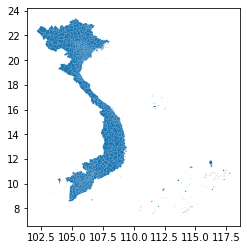

In [279]:
my_geo_df.plot()

In [446]:
geodata = gpd.GeoDataFrame(my_geo_df.merge(dfcluster, how='inner', left_on=['Ten'], right_on=['District Name']))
geodata.sample(10)

,Ten,Province,geometry,ID,cluster_labels,District Name
282,Thị xã La Gi,Binh Thuan Province,"MULTIPOLYGON (((107.80246 10.64985, 107.80191 ...",60594,0,Thị xã La Gi
561,Thành phố Cẩm Phả,Quang Ninh Province,"MULTIPOLYGON (((107.21870 20.95037, 107.21748 ...",22195,1,Thành phố Cẩm Phả
340,Quận Lê Chân,Hai Phong City,"MULTIPOLYGON (((106.68102 20.85489, 106.68547 ...",31305,1,Quận Lê Chân
478,Huyện Đại Từ,Thai Nguyen Province,"MULTIPOLYGON (((105.63047 21.76607, 105.63166 ...",19171,1,Huyện Đại Từ
234,Thành phố Hà Giang,Ha Giang Province,"MULTIPOLYGON (((105.03054 22.87223, 105.03384 ...",2024,5,Thành phố Hà Giang
386,Huyện Bến Lức,Long An Province,"MULTIPOLYGON (((106.39506 10.79472, 106.39879 ...",80803,6,Huyện Bến Lức
380,Huyện Hòa Thành,Tay Ninh Province,"MULTIPOLYGON (((106.13805 11.30529, 106.13835 ...",72709,0,Huyện Hòa Thành
331,Huyện Tương Dương,Nghe An Province,"MULTIPOLYGON (((104.44626 19.65615, 104.44781 ...",40418,3,Huyện Tương Dương
310,Huyện An Minh,Kien Giang Province,"MULTIPOLYGON (((105.05650 9.70330, 105.05577 9...",91909,4,Huyện An Minh
63,Huyện Châu Thành,Tay Ninh Province,"MULTIPOLYGON (((105.98563 11.44699, 106.00706 ...",72708,0,Huyện Châu Thành


In [447]:
type(geodata)

geopandas.geodataframe.GeoDataFrame

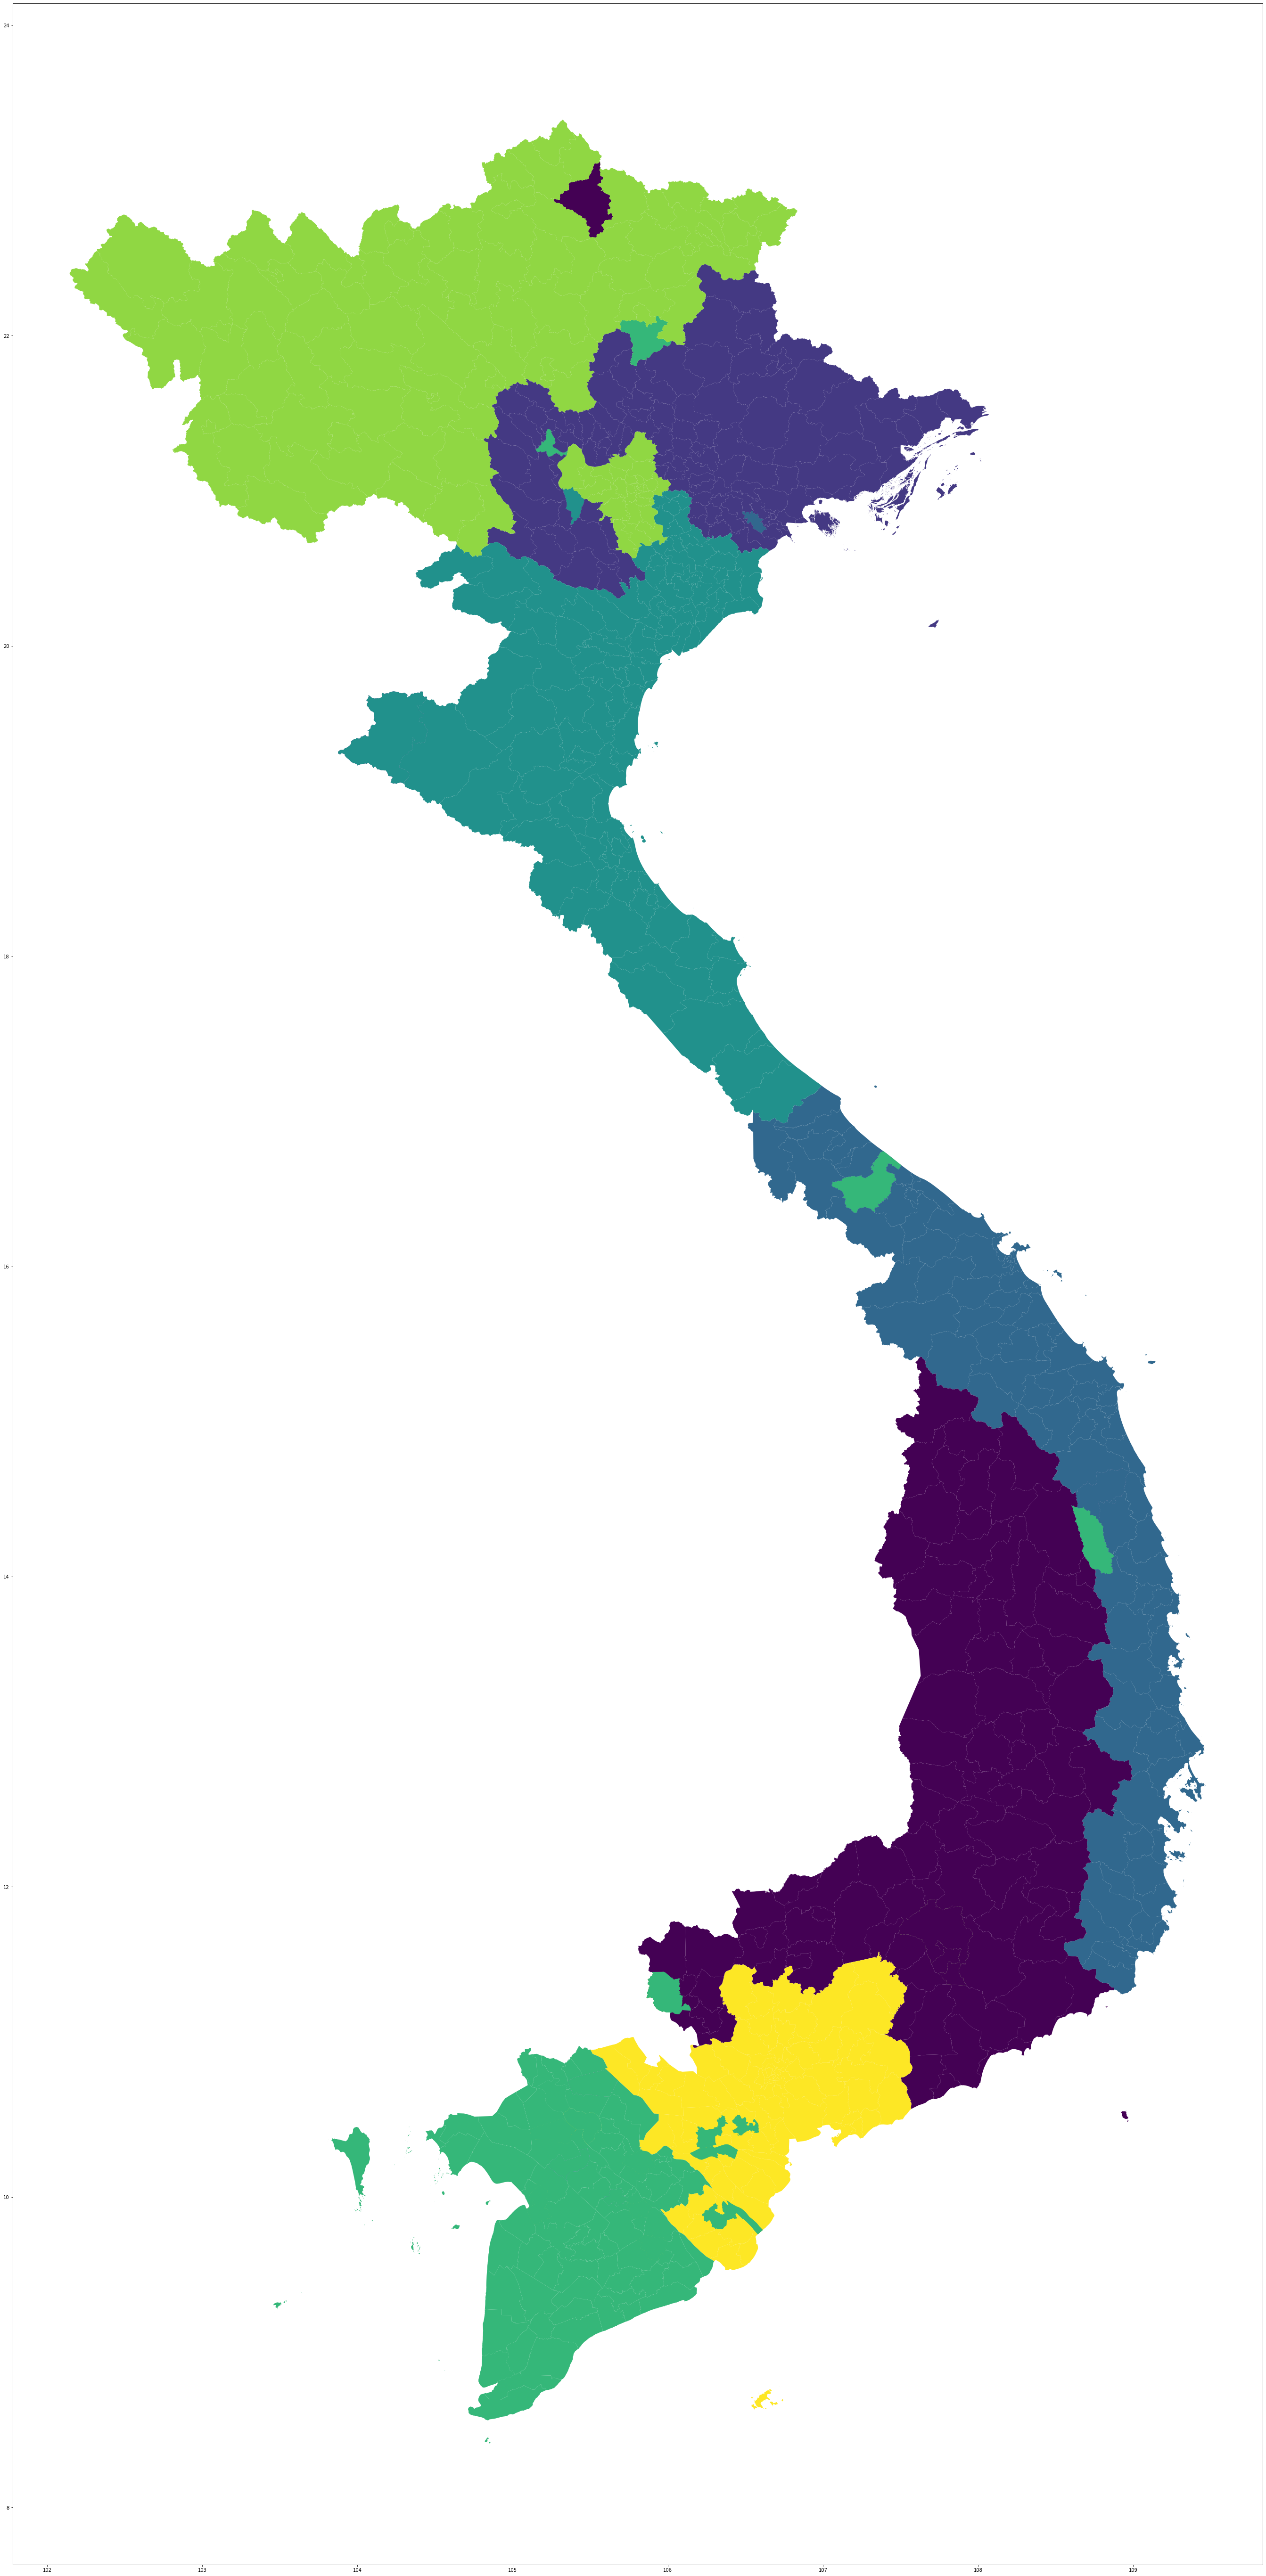

In [448]:
fig = geodata.plot(figsize=(100,100),column=geodata['cluster_labels'])

In [449]:
fig.figure.savefig('Clustering_Kmeans_7_avecGeo.png')

# Clustering hierarchique

In [450]:
dfcluster2= dfstd

In [454]:
dfcluster2=dfcluster.drop(['District Name'], axis=1)

In [455]:

# Hierarchical clustering big picture
from scipy.cluster.hierarchy import fcluster, linkage


# Fit the data into a hierarchical clustering algorithm
distance_matrix = linkage(dfcluster2, 'ward')

# Assign cluster labels to each row of data
dfcluster2['cluster_labels'] = fcluster(distance_matrix, 7, criterion='maxclust')



In [456]:
dfcluster2['District Name']= df['NAME']

In [457]:
dfcluster2=dfcluster2[['ID','cluster_labels','District Name']]
dfcluster2.head()

,ID,cluster_labels,District Name
0,1001,7,Quận Ba Đình
1,1002,7,Quận Hoàn Kiếm
2,1003,7,Quận Tây Hồ
3,1004,7,Quận Long Biên
4,1005,7,Quận Cầu Giấy


In [458]:
geodata = gpd.GeoDataFrame(my_geo_df.merge(dfcluster2, how='inner', left_on=['Ten'], right_on=['District Name']))
geodata.sample(10)

,Ten,Province,geometry,ID,cluster_labels,District Name
146,Huyện Châu Thành,Long An Province,"MULTIPOLYGON (((106.45671 10.52917, 106.46073 ...",83831,2,Huyện Châu Thành
498,Huyện Tây Sơn,Binh Dinh Province,"MULTIPOLYGON (((108.88747 14.13216, 108.88950 ...",52547,4,Huyện Tây Sơn
684,Huyện Phú Thiện,Gia Lai Province,"MULTIPOLYGON (((108.32422 13.61873, 108.34260 ...",64638,1,Huyện Phú Thiện
670,Huyện Nam Sách,Hai Duong Province,"MULTIPOLYGON (((106.36620 21.05821, 106.36337 ...",30291,5,Huyện Nam Sách
570,Huyện Mèo Vạc,Ha Giang Province,"MULTIPOLYGON (((105.41846 23.28507, 105.42117 ...",2027,7,Huyện Mèo Vạc
721,Quận Kiến An,Hai Phong City,"MULTIPOLYGON (((106.66954 20.82157, 106.67045 ...",31307,5,Quận Kiến An
336,Huyện Tĩnh Gia,Thanh Hoa Province,"MULTIPOLYGON (((105.90945 19.31991, 105.90996 ...",38407,5,Huyện Tĩnh Gia
583,Huyện Quan Hóa,Thanh Hoa Province,"MULTIPOLYGON (((104.91784 20.66043, 104.92178 ...",38385,5,Huyện Quan Hóa
340,Quận Lê Chân,Hai Phong City,"MULTIPOLYGON (((106.68102 20.85489, 106.68547 ...",31305,5,Quận Lê Chân
455,Huyện Đoan Hùng,Phu Tho Province,"MULTIPOLYGON (((105.09314 21.71865, 105.09532 ...",25230,6,Huyện Đoan Hùng


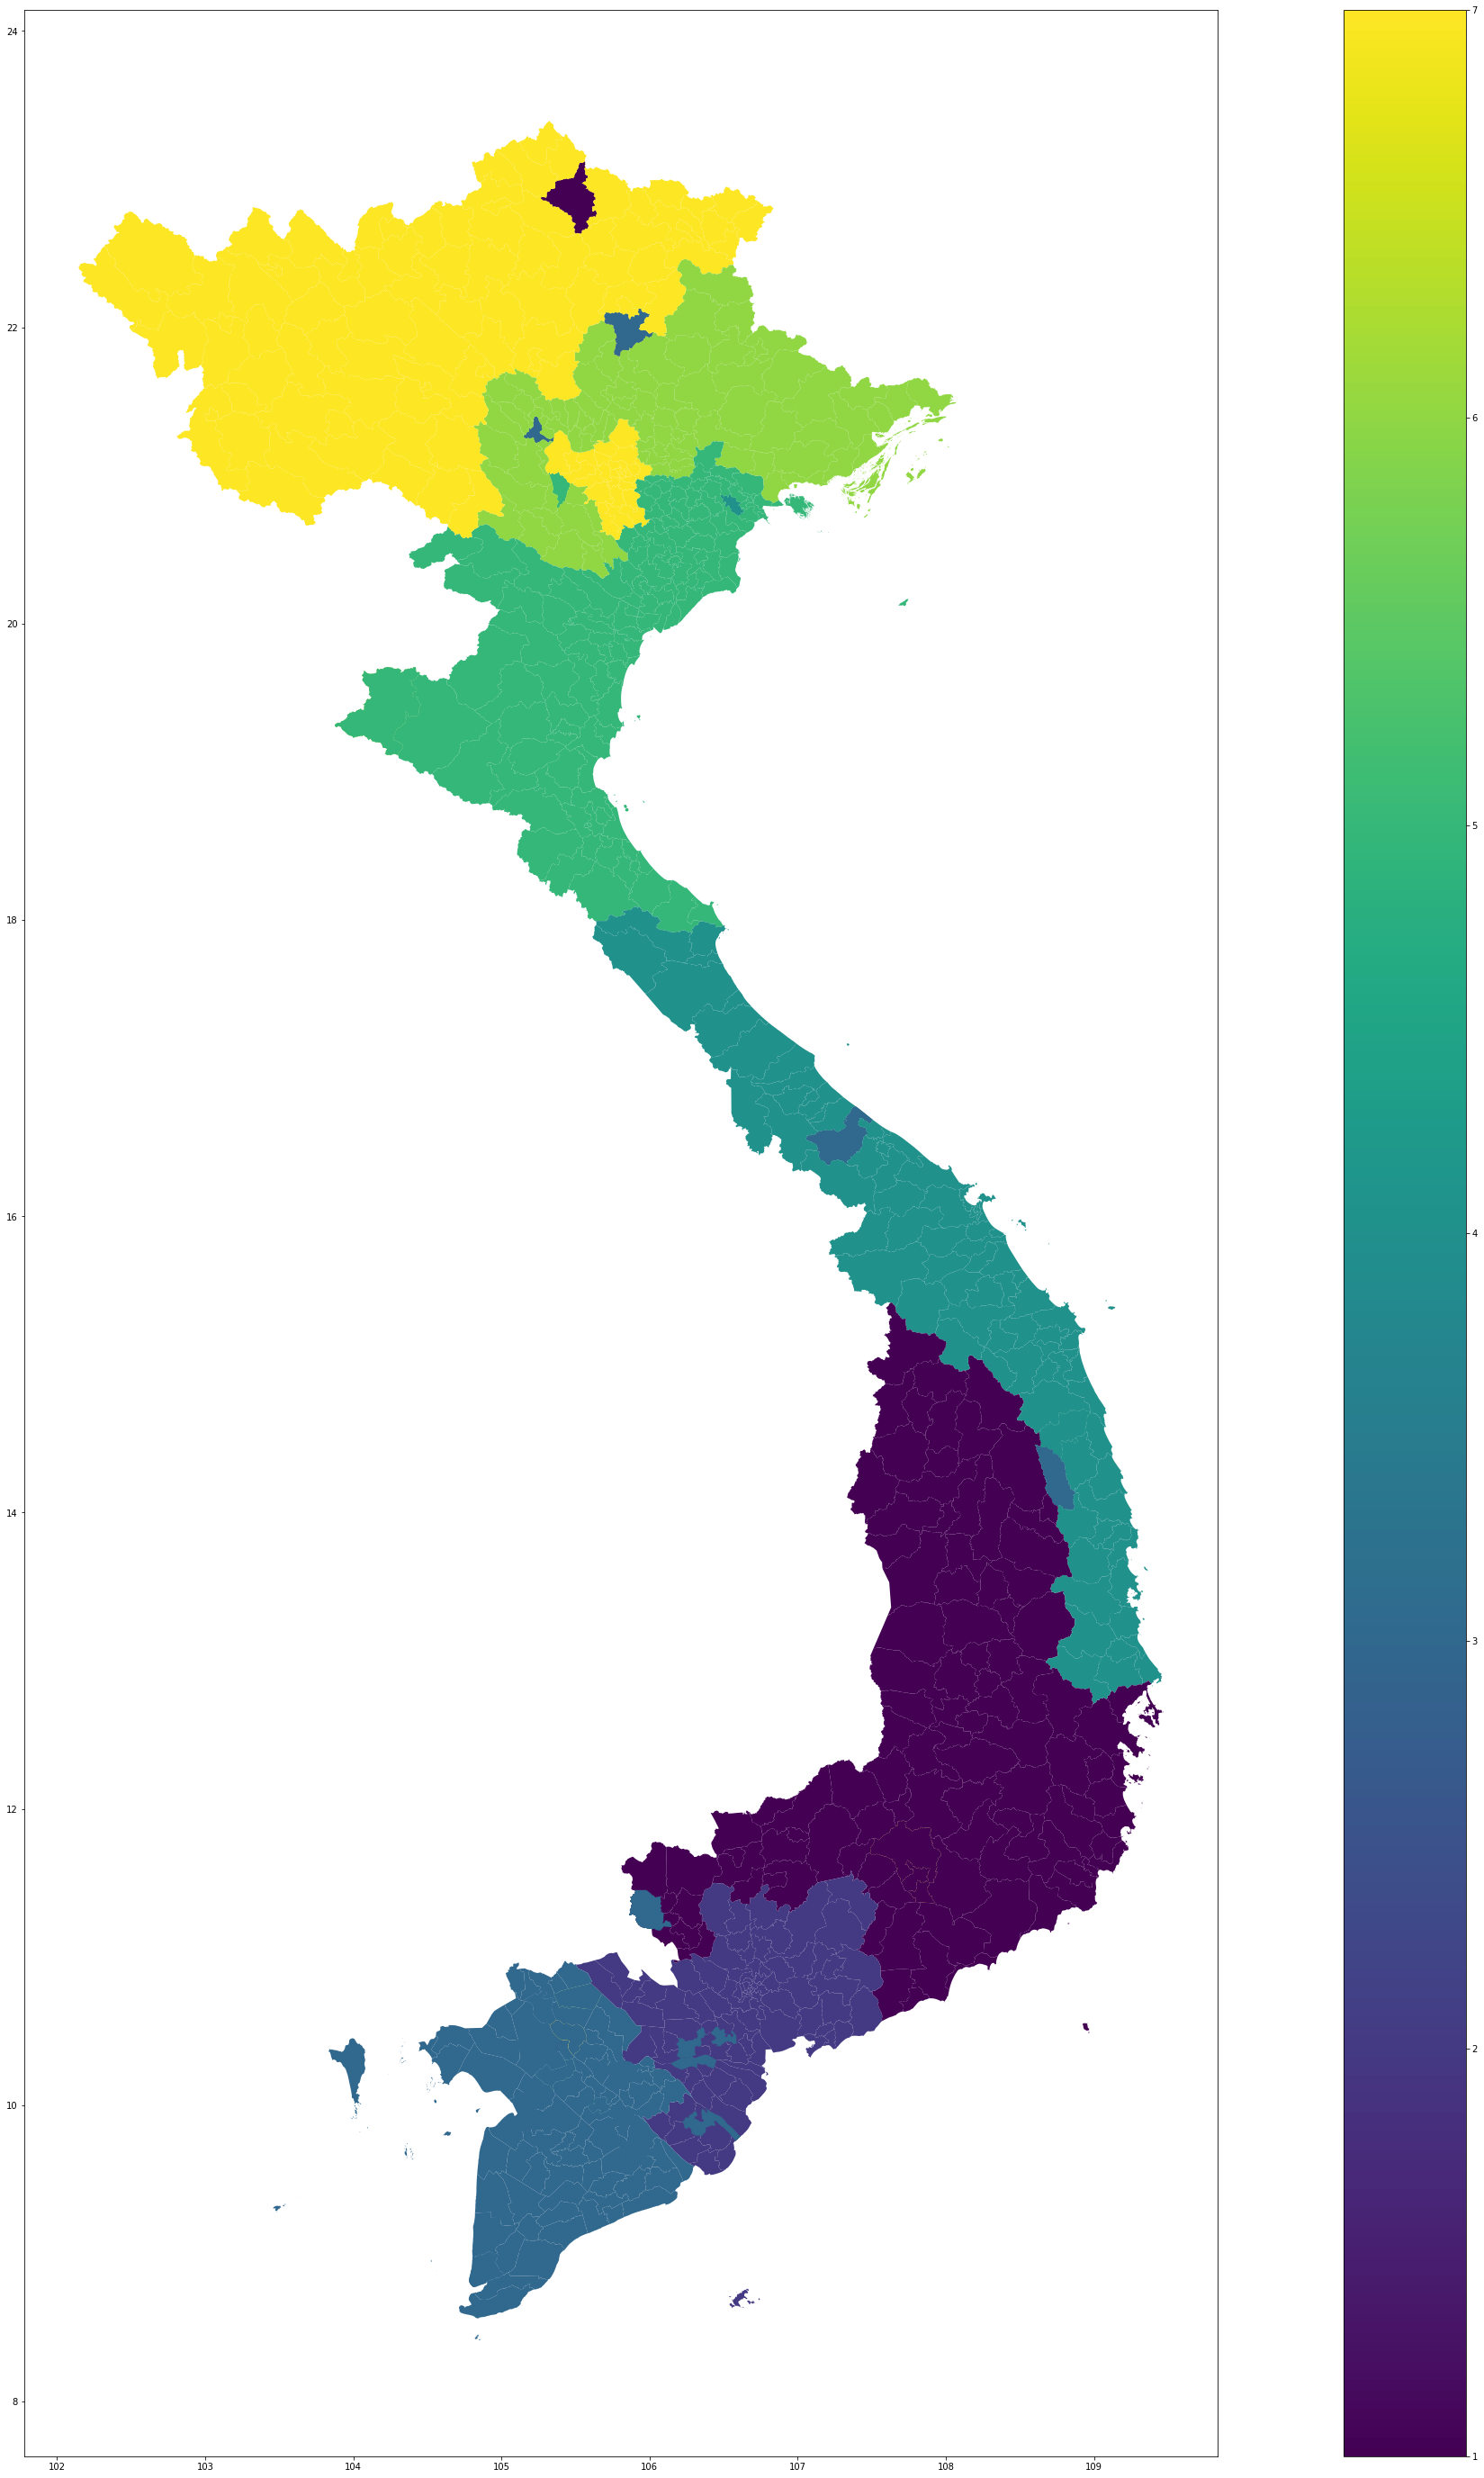

In [477]:

fig = geodata.plot(figsize=(50,50),column=geodata['cluster_labels'],legend=True)

In [478]:
fig.figure.savefig('clustering_ACH_7_avecGeo.png')

In [463]:
# Stat Desc pour les différents clusters.

In [464]:
dfcc=df

In [465]:
dfcc['cluster_label'] = dfcluster2['cluster_labels']

In [466]:
dfcc

,OBJECTID,ID,NAME,2018 Total Population,2018 Population Density (per sq. km),2018 Population Per Mill,2018 Total Male Population,2018 Total Female Population,2018 Total Households,2018 Average Household Size,...,2018 Personal Effects: Total,2018 Personal Effects: Per Mill,2018 Personal Effects: Per Capita,2018 Personal Effects: Index,AREA,grid_code,RG_NAME,Shape__Area,Shape__Length,cluster_label
0,1,1001,Quận Ba Đình,245551,26394.8,2.6,118593,126958,66303,3.7,...,8.801580e+10,4.9,358442.05,190.2,9.303019,471215,Thành phố Hà Nội,1.060136e+07,19745.154516,7
1,2,1002,Quận Hoàn Kiếm,158799,28821.0,1.7,76858,81941,42383,3.7,...,5.337166e+10,3.0,336095.70,178.3,5.509843,248515,Thành phố Hà Nội,6.417896e+06,10122.627004,7
2,3,1003,Quận Tây Hồ,161876,6743.5,1.7,78989,82887,43082,3.8,...,5.223855e+10,2.9,322707.17,171.2,24.004685,420271,Thành phố Hà Nội,2.775605e+07,27415.577234,7
3,4,1004,Quận Long Biên,281598,4880.1,3.0,138675,142923,78111,3.6,...,8.677468e+10,4.9,308150.90,163.5,57.703097,1206280,Thành phố Hà Nội,6.649612e+07,34518.571911,7
4,5,1005,Quận Cầu Giấy,263828,21229.9,2.8,123450,140378,76273,3.5,...,9.722844e+10,5.5,368529.63,195.5,12.427213,622769,Thành phố Hà Nội,1.434960e+07,25685.328783,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,707,96969,Huyện Cái Nước,140755,337.2,1.5,70378,70377,32907,4.3,...,2.054595e+10,1.2,145969.61,77.4,417.409785,42145,Tỉnh Cà Mau,4.302020e+08,95375.181298,3
707,708,96970,Huyện Đầm Dơi,188348,232.1,2.0,93841,94507,43029,4.4,...,2.555806e+10,1.4,135695.96,72.0,811.551773,11286,Tỉnh Cà Mau,8.374241e+08,130464.696975,3
708,709,96971,Huyện Năm Căn,65506,142.7,0.7,33174,32332,16640,3.9,...,1.092790e+10,0.6,166822.84,88.5,459.009102,47217,Tỉnh Cà Mau,4.730924e+08,140193.345872,3
709,710,96972,Huyện Phú Tân,106956,247.6,1.1,53858,53098,24978,4.3,...,1.454268e+10,0.8,135968.85,72.1,432.034322,11700,Tỉnh Cà Mau,4.448235e+08,102367.266184,3


In [468]:
data = dfcc.groupby('cluster_label').describe()

OBJECTID                                                         \
                 count   mean        std    min     25%    50%     75%    max   
cluster_label                                                                   
1                107.0  472.0  31.032241  419.0  445.50  472.0  498.50  525.0   
2                 96.0  573.5  27.856777  526.0  549.75  573.5  597.25  621.0   
3                 90.0  666.5  26.124701  622.0  644.25  666.5  688.75  711.0   
4                 86.0  375.5  24.969982  333.0  354.25  375.5  396.75  418.0   
5                130.0  267.5  37.671829  203.0  235.25  267.5  299.75  332.0   
6                 85.0  160.0  24.681302  118.0  139.00  160.0  181.00  202.0   
7                117.0   59.0  33.919021    1.0   30.00   59.0   88.00  117.0   

                  ID                ...   Shape__Area                \
               count          mean  ...           75%           max   
cluster_label                       ...                               
1              107.0  65333.429907  ...  1.141805e+09  1.971732e+09   
2               96.0  80034.489583  ...  3.558026e+08  1.137023e+09   
3               90.0  92147.855556  ...  4.479443e+08  1.088190e+09   
4               86.0  49415.174419  ...  8.019282e+08  2.329709e+09   
5              130.0  36562.723077  ...  3.755049e+08  3.166426e+09   
6               85.0  22571.505882  ...  6.460787e+08  1.378749e+09   
7              117.0   6995.957265  ...  1.085413e+09  3.184346e+09   

              Shape__Length                                              \
                      count           mean            std           min   
cluster_label                                                             
1                     107.0  163906.289338   59808.470014  28965.583830   
2                      96.0   85781.919662   45018.250620   9649.513943   
3                      90.0   94436.194878   32070.352379  30447.258392   
4                      86.0  132025.637380   58035.641844   6388.668888   
5                     130.0  108077.813426   63627.096015   8385.692765   
6                      85.0  140579.908849  115924.125703  43886.556157   
7                     117.0  149740.631826   80919.863981  10122.627004   

                                                                           
                         25%            50%            75%            max  
cluster_label                                                              
1              121790.240927  161980.850044  208348.360405  330941.296995  
2               56848.817849   88721.343939  111212.090940  260577.248397  
3               76683.533020   94069.572622  107942.901888  199156.146838  
4               86587.829762  121666.902579  176928.429675  262807.144152  
5               65390.511830   88283.152775  134952.758272  402012.524613  
6               83695.340327  117753.228195  162428.370446  926047.134041  
7               79225.194085  149818.948629  201615.736296  376366.368185  

[7 rows x 1000 columns]

In [ ]:
data.to_csv()